Klasifikasi Kucing & Anjing

Metode: CNN (VGG16 pretrained + custom classifier)

Fitur: TFDS (fallback), preprocessing, training, visualisasi, GUI upload gambar (ipywidgets)

In [ ]:
!pip install -q tensorflow-datasets ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.6 MB/s eta 0:00:00


In [ ]:
import os, random, shutil, io
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tampilkan versi
print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


In [ ]:

#Mengunduh dataset TFDS cats_vs_dogs (akan otomatis) dan simpan sampel ke folder

WORK_DIR = "data_tfs_cats_dogs"
TRAIN_RAW = os.path.join(WORK_DIR, "train_raw")
VAL_RAW = os.path.join(WORK_DIR, "val_raw")
os.makedirs(TRAIN_RAW, exist_ok=True)
os.makedirs(VAL_RAW, exist_ok=True)

print("Mengunduh dataset cats_vs_dogs via TFDS (bisa memakan waktu beberapa menit)...")
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
print("Dataset TFDS didownload. Jumlah contoh (perkiraan):", ds_info.splits['train'].num_examples)

Mengunduh dataset cats_vs_dogs via TFDS (bisa memakan waktu beberapa menit)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.O32EZD_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset TFDS didownload. Jumlah contoh (perkiraan): 23262


In [ ]:
#Menyimpan beberapa sampel didalam folder sebagai file gambar

def save_samples_from_tfds(ds, out_dir, limit=None, start_index=0):
    os.makedirs(out_dir, exist_ok=True)
    i = start_index
    for image, label in tfds.as_numpy(ds):
        img = Image.fromarray(image)
        label_str = "dog" if int(label)==1 else "cat"
        fname = f"{label_str}.{i}.jpg"
        img.save(os.path.join(out_dir, fname))
        i += 1
        if limit and i - start_index >= limit:
            break
    return i - start_index


print("Menyimpan sampel train (max 2400) dan val (max 800)...")
saved_train = save_samples_from_tfds(ds_train, TRAIN_RAW, limit=2400, start_index=0)
saved_val = save_samples_from_tfds(ds_val, VAL_RAW, limit=800, start_index=0)
print("Tersimpan - train:", saved_train, "val:", saved_val)

Menyimpan sampel train (max 2400) dan val (max 800)...
Tersimpan - train: 2400 val: 800


In [ ]:
BASE_DIR = "data/cats_and_dogs_filtered"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")

# Hapus jika sudah ada (opsional untuk reset)
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)
os.makedirs(os.path.join(TRAIN_DIR, "cats"), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, "dogs"), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, "cats"), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, "dogs"), exist_ok=True)

# Ambil file dari TRAIN_RAW & VAL_RAW
source_train_files = [f for f in os.listdir(TRAIN_RAW) if f.lower().endswith(('.jpg','.jpeg','.png'))]
source_val_files = [f for f in os.listdir(VAL_RAW) if f.lower().endswith(('.jpg','.jpeg','.png'))]

cats_files = [f for f in source_train_files if 'cat' in f.lower()]
dogs_files = [f for f in source_train_files if 'dog' in f.lower()]

# Jika jumlah tidak seimbang, tambahkan dari source_val_files
if len(cats_files) < 100 or len(dogs_files) < 100:
    cats_files += [f for f in source_val_files if 'cat' in f.lower()]
    dogs_files += [f for f in source_val_files if 'dog' in f.lower()]

print("Jumlah sumber cat:", len(cats_files), "dog:", len(dogs_files))

random.shuffle(cats_files)
random.shuffle(dogs_files)

Jumlah sumber cat: 1227 dog: 1173


In [ ]:
train_per_class = min(1000, len(cats_files), len(dogs_files))
val_per_class = min(400, max(0, len(cats_files)-train_per_class), max(0, len(dogs_files)-train_per_class))

# copy file (from TRAIN_RAW or VAL_RAW if not found)
def copy_if_exists(fname, src_dirs, dst_dir):
    for s in src_dirs:
        src_path = os.path.join(s, fname)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_dir)
            return True
    return False

In [ ]:
# Copy cats
for i, f in enumerate(cats_files[:train_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(TRAIN_DIR, "cats"))
for i, f in enumerate(cats_files[train_per_class:train_per_class+val_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(VAL_DIR, "cats"))

# Copy dogs
for i, f in enumerate(dogs_files[:train_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(TRAIN_DIR, "dogs"))
for i, f in enumerate(dogs_files[train_per_class:train_per_class+val_per_class]):
    copy_if_exists(f, [TRAIN_RAW, VAL_RAW], os.path.join(VAL_DIR, "dogs"))

print("Selesai memindahkan data.")
print(" - Train cats:", len(os.listdir(os.path.join(TRAIN_DIR,"cats"))))
print(" - Train dogs:", len(os.listdir(os.path.join(TRAIN_DIR,"dogs"))))
print(" - Val cats:", len(os.listdir(os.path.join(VAL_DIR,"cats"))))
print(" - Val dogs:", len(os.listdir(os.path.join(VAL_DIR,"dogs"))))


Selesai memindahkan data.
 - Train cats: 1000
 - Train dogs: 1000
 - Val cats: 173
 - Val dogs: 173


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 346 images belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
EPOCHS = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 769ms/step - accuracy: 0.6456 - loss: 0.6444 - val_accuracy: 0.8873 - val_loss: 0.2819
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 448ms/step - accuracy: 0.8664 - loss: 0.3427 - val_accuracy: 0.9191 - val_loss: 0.2224
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - accuracy: 0.8497 - loss: 0.3150 - val_accuracy: 0.9249 - val_loss: 0.2068
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - accuracy: 0.8934 - loss: 0.2599 - val_accuracy: 0.9335 - val_loss: 0.1908
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - accuracy: 0.9086 - loss: 0.2431 - val_accuracy: 0.9306 - val_loss: 0.1852


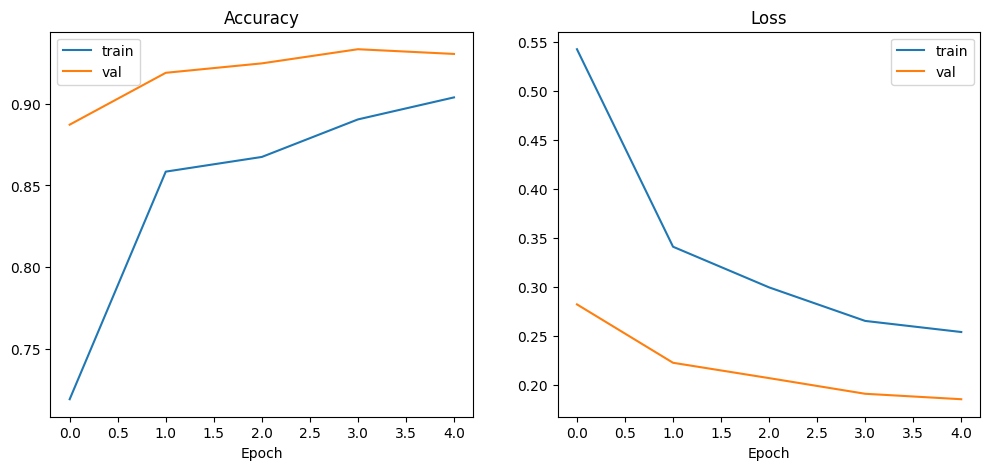

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train')
plt.plot(history.history.get('val_accuracy', []), label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train')
plt.plot(history.history.get('val_loss', []), label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
model.save("vgg16_cats_dogs_uts.h5")
print("Model tersimpan sebagai: vgg16_cats_dogs_uts.h5")

Model tersimpan sebagai: vgg16_cats_dogs_uts.h5


In [ ]:
from ipywidgets import FileUpload, Label, Output
from IPython.display import display
import matplotlib.pyplot as plt

upload = FileUpload(accept='image/*', multiple=False)
label = Label(value="Upload gambar kucing/anjing untuk prediksi")
output_img = Output()

def on_upload_change(change):
    if len(upload.value) == 0:
        return
    for name, file_info in upload.value.items():
        content = file_info['content']
        img = Image.open(io.BytesIO(content)).convert('RGB')

        # tampilkan gambar
        with output_img:
            output_img.clear_output(wait=True)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

        # preprocess & prediksi
        img_resized = img.resize((IMG_SIZE, IMG_SIZE))
        arr = np.array(img_resized)/255.0
        arr = np.expand_dims(arr, axis=0)

        pred = model.predict(arr)[0][0]
        if pred > 0.5:
            kelas = "Anjing 🐶"
        else:
            kelas = "Kucing 🐱"

        label.value = f"Prediksi: {kelas}    Probabilitas (sigmoid): {pred:.4f}"

upload.observe(on_upload_change, names='value')

display(label)
display(upload)
display(output_img)

Label(value='Upload gambar kucing/anjing untuk prediksi')

FileUpload(value={}, accept='image/*', description='Upload')

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
import io
import numpy as np
from PIL import Image
from ipywidgets import FileUpload, Label, Output, VBox
from IPython.display import display
import matplotlib.pyplot as plt

upload = FileUpload(accept='image/*', multiple=True)   # <= MULTIPLE TRUE
label = Label(value="Upload hingga 4 gambar kucing/anjing untuk prediksi")
output_img = Output()

def on_upload_change(change):
    files = upload.value

    if len(files) == 0:
        return

    with output_img:
        output_img.clear_output(wait=True)

        # Maksimal tampilkan 4 gambar
        max_images = min(4, len(files))

        plt.figure(figsize=(10, 10))

        i = 1
        for name, file_info in list(files.items())[:max_images]:
            content = file_info['content']
            img = Image.open(io.BytesIO(content)).convert('RGB')

            # Preprocess
            img_resized = img.resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img_resized) / 255.0
            arr = np.expand_dims(arr, axis=0)

            # Predict
            pred = model.predict(arr)[0][0]
            kelas = "Anjing 🐶" if pred > 0.5 else "Kucing 🐱"

            # Tampilkan gambar
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(f"{kelas}\nProb: {pred:.4f}")
            plt.axis("off")
            i += 1

        plt.show()

upload.observe(on_upload_change, names='value')

display(VBox([label, upload, output_img]))


In [1]:
!curl -L -o VGGNet.ipynb \
"https://raw.githubusercontent.com/Yosefin07/UTS_DeepLearning_CNN/main/VGGNet.ipynb"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1085k  100 1085k    0     0  1462k      0 --:--:-- --:--:-- --:--:-- 1460k


In [2]:
import os
os.listdir()


['.config', 'VGGNet.ipynb', 'sample_data']

In [3]:
import nbformat as nbf

input_nb = "VGGNet.ipynb"
output_nb = "VGGNet_CLEAN.ipynb"

with open(input_nb, "r", encoding="utf-8") as f:
    nb = nbf.read(f, as_version=4)

# Hapus metadata widgets dan state
bad_keys = ["widgets", "state"]

# Hapus metadata utama notebook
if "widgets" in nb.metadata:
    del nb.metadata["widgets"]
if "state" in nb.metadata:
    del nb.metadata["state"]

# Hapus metadata tiap cell
for cell in nb.cells:
    for key in bad_keys:
        if key in cell.metadata:
            del cell.metadata[key]

    # Hapus seluruh data widgets (jika masih ada)
    if "widgets" in cell.metadata:
        del cell.metadata["widgets"]

# Hapus output agar lebih ringan
for cell in nb.cells:
    if cell.cell_type == "code":
        cell.outputs = []
        cell.execution_count = None

with open(output_nb, "w", encoding="utf-8") as f:
    nbf.write(nb, f)

print("SUCCESS → Notebook cleaned:", output_nb)


SUCCESS → Notebook cleaned: VGGNet_CLEAN.ipynb
